# ARIMA

- Proceso aplicado a cada ciudad por separado
- Se ha incluido GridSearch
- Se ha mejorado la imputación de datos, la mejor solución se obtiene eliminando las filas vacias pero la submision da problemas al faltar registros.
- Eliminaremos variables con poca correlacion y con muchos missing values para evitar imputar demasiados datos que desvien los resultados.
- Se usan la mediana de los valores climatologicos del último mes (4 semanas) ya que, aumenta la correlacion usando parte del historico.  


## Import libraries

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("whitegrid")

import warnings
warnings.filterwarnings('ignore')

import dengue_utils as dutils
import dsutils as du


In [2]:
# Load dataset

features_train = pd.read_csv('../data/dengue_features_train.csv')
labels_train   = pd.read_csv('../data/dengue_labels_train.csv')

features_test = pd.read_csv('../data/dengue_features_test.csv')

dengue_dataset = pd.concat([features_train, features_test], axis = 0)

# Join train labes and features
dengue_dataset_labeled = dengue_dataset.merge(labels_train, 
                                           left_on = ['city', 'year', 'weekofyear'], 
                                           right_on = ['city', 'year', 'weekofyear'],
                                           how = 'outer')


features_test.columns

Index(['city', 'year', 'weekofyear', 'week_start_date', 'ndvi_ne', 'ndvi_nw',
       'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm'],
      dtype='object')

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


Mostramos la variable **total_cases** y su evolucion en el tiempo. 

Creamos el dataframe *dengue_cases_time* con las variables fecha y total_cases, para una de las ciudades: *sj*

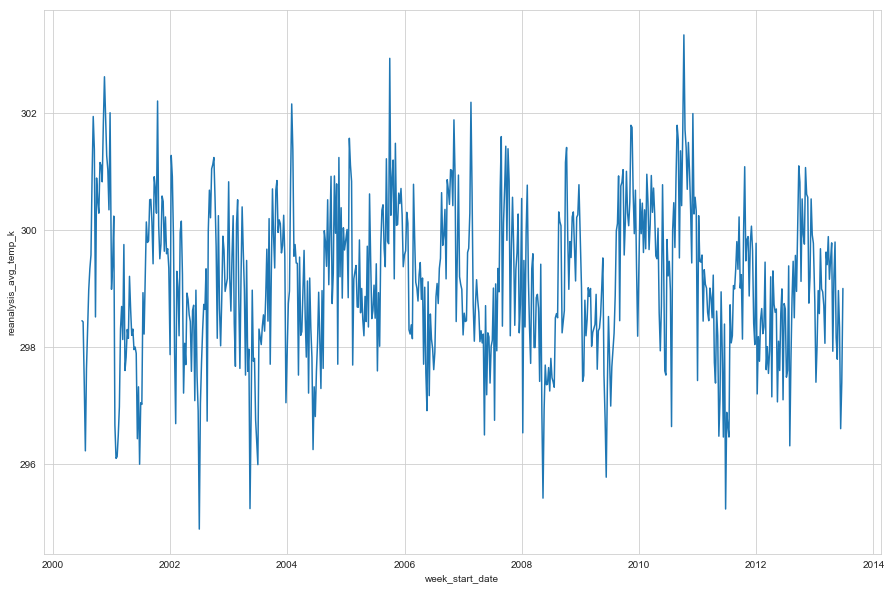

In [4]:
# Get date-cases for one city

variable = "reanalysis_avg_temp_k"
#variable = "total_cases"
dengue_cases_time = dengue_dataset_labeled.loc[dengue_dataset_labeled.city == 'iq', 
                                               ['week_start_date', variable, 'reanalysis_sat_precip_amt_mm', 'weekofyear']]

dengue_cases_time['week_start_date'] = pd.to_datetime(dengue_cases_time['week_start_date'])

du.show_lineplot(dengue_cases_time, xvalue='week_start_date', yvalue=variable)

Los análisis mediante series temporales tienen como entrada un dataframe que suelen tener como índice la fecha o la variable temporal, por ello, en este bloque establecemos como índice *week_start_date*

In [5]:
import statsmodels.api as sm

if dengue_cases_time.index.name == None:
    dengue_cases_time = dengue_cases_time.set_index('week_start_date')

dengue_cases_time.head()

,reanalysis_avg_temp_k,reanalysis_sat_precip_amt_mm,weekofyear
week_start_date,,,
2000-07-01,298.450000,25.41,26
2000-07-08,298.428571,60.61,27
2000-07-15,297.392857,55.52,28
2000-07-22,296.228571,5.60,29
2000-07-29,297.635714,62.76,30


# Quick Check for Autocorrelation
https://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/

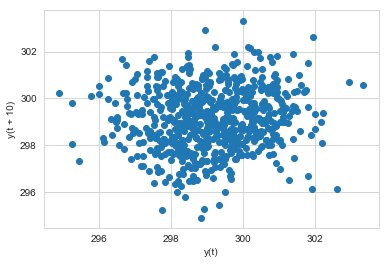

In [6]:
from pandas import Series
from matplotlib import pyplot
from pandas.tools.plotting import lag_plot

dengue_cases_time = dengue_cases_time.dropna()

series = dengue_cases_time[variable]
lag_plot(series, lag=10)
pyplot.show()

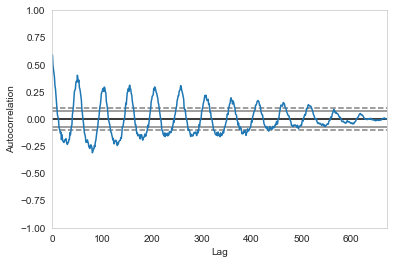

In [7]:
from pandas.tools.plotting import autocorrelation_plot
autocorrelation_plot(series)
pyplot.show()

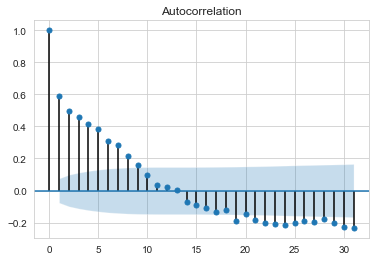

In [8]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(series, lags=31)
pyplot.show()

We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise.

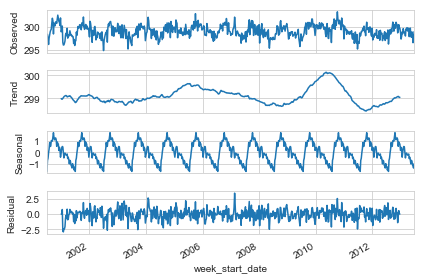

In [9]:
from plotly.plotly import plot_mpl
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = sm.tsa.seasonal_decompose(series, model='additive', freq=52)
fig = decomposition.plot()

https://www.sciencedirect.com/topics/chemistry/autocorrelation-function

**Autocrrelation function**

- The autocorrelation function (ACF) reveals how the correlation between any two values of the signal changes as their separation changes.

- A white noise process has an autocorrelation function of zero at all lags except a value of unity at lag zero, to indicate that the process is completely uncorrelated.

- A correlated process on the other hand, such as ARMA or ARIMA, has non-zero values at lags other than zero to indicate a correlation between different lagged observations.


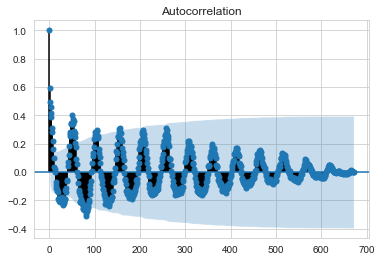

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
   
plot_acf(series)
pyplot.show()

# Simple linear regression

In [11]:
dengue_cases_time_train = dengue_cases_time[dengue_cases_time.index < '2009-01-01']

X_train = dengue_cases_time_train[['weekofyear', 'reanalysis_sat_precip_amt_mm']]
y_train = dengue_cases_time_train[variable]

dengue_cases_time_test = dengue_cases_time[dengue_cases_time.index >= '2009-01-01']
X_test = dengue_cases_time_test[['weekofyear', 'reanalysis_sat_precip_amt_mm']]
y_test = dengue_cases_time_test[variable]

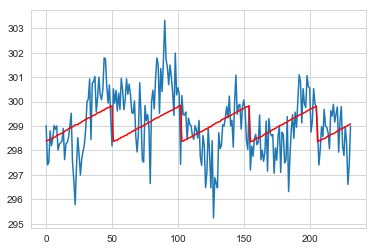

In [15]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression(normalize=True).fit(X_train, y_train)

yhat = reg.predict(X_test)

metrics = du.get_metrics(y_test, yhat)

# plot predictions vs expected
pyplot.plot(y_test.values)
pyplot.plot(yhat, color='red')
#pyplot.ylim(0, 40)
pyplot.show()

In [16]:
metrics

(0.9485897820063026, 0.1297651285682363, 0.1313750910287257)

# Time series

In [17]:
dengue_cases_time = dengue_cases_time.dropna()

dengue_cases_time_train = dengue_cases_time[dengue_cases_time.index < '2009-01-01']

data_train = dengue_cases_time_train[variable].values
exog_data_train  = dengue_cases_time_train.reanalysis_sat_precip_amt_mm.values

dengue_cases_time_test = dengue_cases_time[dengue_cases_time.index >= '2009-01-01']

data_test = dengue_cases_time_test[variable].values
exog_data_test = dengue_cases_time_test.reanalysis_sat_precip_amt_mm.values


## Autoregressive model (AR)

In [18]:
# AR example
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA, ARMA
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot

Metrics MAE, R2, Explained variance: (1.0445747140013786, -0.003530313280459385, -0.003529812263107557)


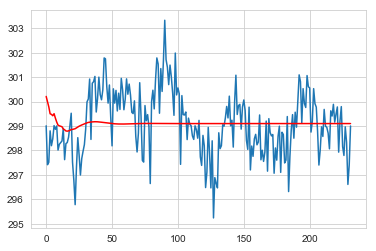

In [19]:
# fit model
model = AR(data_train)
model_fit = model.fit()

yhat = model_fit.predict(start=len(data_train), end=len(data_train)+len(data_test)-1, dynamic=False)
len(yhat) == len(data_test)

metrics = du.get_metrics(data_test, yhat)
print('Metrics MAE, R2, Explained variance: ' + str(metrics))

# plot predictions vs expected
pyplot.plot(data_test)
pyplot.plot(yhat, color='red')
pyplot.show()

# Moving average (MA)

We can use the ARMA class to create an MA model and setting a zeroth-order AR model. We must specify the order of the MA model in the order argument.

Metrics MAE, R2, Explained variance: (1.0424032658887696, -0.0012186571786345635, -0.0011143402844735473)


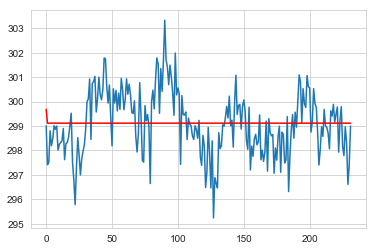

In [20]:
# fit model
model = ARMA(data_train, order=(0, 1))
model_fit = model.fit()

yhat = model_fit.predict(start=len(data_train), end=len(data_train)+len(data_test)-1)

metrics = du.get_metrics(data_test, yhat)
print('Metrics MAE, R2, Explained variance: ' + str(metrics))

# plot predictions vs expected
pyplot.plot(data_test)
pyplot.plot(yhat, color='red')
pyplot.show()

# Autoregressive moving average (ARMA)

Metrics MAE, R2, Explained variance: (1.0708241107391847, -0.03925407269385417, -0.03795718065693321)


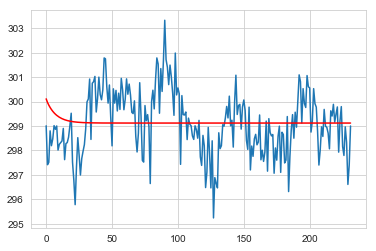

In [21]:
# fit model
model = ARMA(data_train, order=(2, 1))
model_fit = model.fit()

yhat = model_fit.predict(start=len(data_train), end=len(data_train)+len(data_test)-1)

metrics = du.get_metrics(data_test, yhat)
print('Metrics MAE, R2, Explained variance: ' + str(metrics))

# plot predictions vs expected
pyplot.plot(data_test)
pyplot.plot(yhat, color='red')
pyplot.show()

# Autoregressive integrated moving average (ARIMA)

https://github.com/gmonaci/ARIMA/blob/master/time-series-analysis-ARIMA.ipynb

In [26]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools

# Define the d and q parameters to take any value between 0 and 1
q = d = range(1, 3)
# Define the p parameters to take any value between 0 and 3
p = range(0, 4)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

min_mae = 100
min_metrics = []
min_params = []
min_seasonality_params = []

for params in pdq:
    for seasonality_params in seasonal_pdq:
        model = SARIMAX(data_train, 
                        exog=exog_data_train,
                        order=params, 
                        seasonal_order=seasonality_params, 
                        enforce_stationarity=False, 
                        enforce_invertibility=False)
        
        model_fit = model.fit(disp=False)

        yhat = model_fit.predict(start=len(data_train), end=len(data_train)+len(data_test)-1, exog=np.asmatrix(exog_data_test).transpose())

        metrics = du.get_metrics(data_test, yhat)
        #print('Metrics MAE, R2, Explained variance: ' + str(metrics))

        if metrics[0] < min_mae:
            min_mae = metrics[0]
            min_metrics = metrics
            min_params = params
            min_seasonality_params = seasonality_params
            
        print("order: " + str(params) + " seasonality " + str(seasonality_params) + " mae " + str(metrics[0]) + " r2 " + str(metrics[1]))
        
        
# plot predictions vs expected
# pyplot.plot(data)
# pyplot.plot(ar_list, color='red')
# pyplot.show()

#len(data)

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 1, 2) x (0, 1, 2, 12)
SARIMAX: (0, 1, 2) x (0, 2, 1, 12)
SARIMAX: (0, 2, 1) x (0, 2, 2, 12)
SARIMAX: (0, 2, 1) x (1, 1, 1, 12)
order: (0, 1, 1) seasonality (0, 1, 1, 12) mae 1.9441859116045785 r2 -2.1152341502415735
order: (0, 1, 1) seasonality (0, 1, 2, 12) mae 1.2915845023992296 r2 -0.5159616887233918
order: (0, 1, 1) seasonality (0, 2, 1, 12) mae 4.189441599950196 r2 -11.857212281027374
order: (0, 1, 1) seasonality (0, 2, 2, 12) mae 3.380971550795629 r2 -8.755492547684488
order: (0, 1, 1) seasonality (1, 1, 1, 12) mae 1.4763353737258027 r2 -0.9043882057073611
order: (0, 1, 1) seasonality (1, 1, 2, 12) mae 1.5526273677287208 r2 -1.0869694936739238
order: (0, 1, 1) seasonality (1, 2, 1, 12) mae 12.77642741628744 r2 -124.28073248700409
order: (0, 1, 1) seasonality (1, 2, 2, 12) mae 2.4589343543392332 r2 -4.037225635575573
order: (0, 1, 1) seasonality (2, 1, 1, 12) mae 1.2625529402547622 r2 -0.4332239131360953


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



order: (0, 1, 1) seasonality (2, 1, 2, 12) mae 1.3821166323387428 r2 -0.6884597022325665
order: (0, 1, 1) seasonality (2, 2, 1, 12) mae 11.341745049966589 r2 -103.93925567914843


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



order: (0, 1, 1) seasonality (2, 2, 2, 12) mae 3.9942084284011012 r2 -12.224290664541062
order: (0, 1, 1) seasonality (3, 1, 1, 12) mae 1.417019782868783 r2 -0.7459773759961104
order: (0, 1, 1) seasonality (3, 1, 2, 12) mae 1.3344547603812724 r2 -0.5698640811027311


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



order: (0, 1, 1) seasonality (3, 2, 1, 12) mae 9.67297243766847 r2 -76.87492854737957


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



order: (0, 1, 1) seasonality (3, 2, 2, 12) mae 2.694971535059889 r2 -4.98184500079543
order: (0, 1, 2) seasonality (0, 1, 1, 12) mae 1.9595306260427174 r2 -2.1625151941688183
order: (0, 1, 2) seasonality (0, 1, 2, 12) mae 1.276678103208366 r2 -0.48220116482838815
order: (0, 1, 2) seasonality (0, 2, 1, 12) mae 4.091444570891232 r2 -11.2598403457837
order: (0, 1, 2) seasonality (0, 2, 2, 12) mae 3.191235407272001 r2 -7.721928761147735
order: (0, 1, 2) seasonality (1, 1, 1, 12) mae 1.4357853906414864 r2 -0.8100678405914357
order: (0, 1, 2) seasonality (1, 1, 2, 12) mae 1.5182074591894514 r2 -1.0039150334105522
order: (0, 1, 2) seasonality (1, 2, 1, 12) mae 13.036215304723857 r2 -130.23586422358966


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



order: (0, 1, 2) seasonality (1, 2, 2, 12) mae 2.3815944714771264 r2 -3.733584984578365
order: (0, 1, 2) seasonality (2, 1, 1, 12) mae 1.271940020693525 r2 -0.4481067814194415


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



order: (0, 1, 2) seasonality (2, 1, 2, 12) mae 1.3726819579498402 r2 -0.6662565237782083
order: (0, 1, 2) seasonality (2, 2, 1, 12) mae 11.342627891800378 r2 -103.96869258419915


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



order: (0, 1, 2) seasonality (2, 2, 2, 12) mae 3.9305075283604856 r2 -11.851791086646124


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



order: (0, 1, 2) seasonality (3, 1, 1, 12) mae 1.4124698339761341 r2 -0.7330410224347337


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



order: (0, 1, 2) seasonality (3, 1, 2, 12) mae 1.2536745292878115 r2 -0.40568264618169136
order: (0, 1, 2) seasonality (3, 2, 1, 12) mae 9.328587589275763 r2 -71.43461243829596


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



order: (0, 1, 2) seasonality (3, 2, 2, 12) mae 7.8146013758030115 r2 -49.3366129283038
order: (0, 2, 1) seasonality (0, 1, 1, 12) mae 2.9031111530208324 r2 -5.589269153102438
order: (0, 2, 1) seasonality (0, 1, 2, 12) mae 2.9807387688454234 r2 -5.929927985646851
order: (0, 2, 1) seasonality (0, 2, 1, 12) mae 8.641047459149123 r2 -67.96142947849482
order: (0, 2, 1) seasonality (0, 2, 2, 12) mae 6.692228367898392 r2 -37.102404914722584
order: (0, 2, 1) seasonality (1, 1, 1, 12) mae 2.9677036530382312 r2 -5.8604084377607295
order: (0, 2, 1) seasonality (1, 1, 2, 12) mae 2.4061005821482797 r2 -3.5687761700749787
order: (0, 2, 1) seasonality (1, 2, 1, 12) mae 27.009612691730112 r2 -677.6447716190347
order: (0, 2, 1) seasonality (1, 2, 2, 12) mae 6.700667599472556 r2 -37.20252986454385
order: (0, 2, 1) seasonality (2, 1, 1, 12) mae 2.9740516182238603 r2 -5.888074711907625


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



order: (0, 2, 1) seasonality (2, 1, 2, 12) mae 3.805866326293334 r2 -10.354603858323907
order: (0, 2, 1) seasonality (2, 2, 1, 12) mae 14.476434207965518 r2 -178.8000064026582
order: (0, 2, 1) seasonality (2, 2, 2, 12) mae 11.052279699128075 r2 -101.61371643672894


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



order: (0, 2, 1) seasonality (3, 1, 1, 12) mae 2.8274770758251773 r2 -5.374191961771406


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



order: (0, 2, 1) seasonality (3, 1, 2, 12) mae 3.483715574284372 r2 -8.443104777779624


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



order: (0, 2, 1) seasonality (3, 2, 1, 12) mae 13.922594246679997 r2 -165.26720322583233


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



order: (0, 2, 1) seasonality (3, 2, 2, 12) mae 13.164495649604312 r2 -144.14667247271174
order: (0, 2, 2) seasonality (0, 1, 1, 12) mae 1.826228113563263 r2 -1.789927892834518
order: (0, 2, 2) seasonality (0, 1, 2, 12) mae 4.10545327480392 r2 -12.559356006577035
order: (0, 2, 2) seasonality (0, 2, 1, 12) mae 19.661287052400017 r2 -369.4644372095308
order: (0, 2, 2) seasonality (0, 2, 2, 12) mae 6.624623930583898 r2 -37.16783262730162
order: (0, 2, 2) seasonality (1, 1, 1, 12) mae 3.317397456977234 r2 -7.835816027014772
order: (0, 2, 2) seasonality (1, 1, 2, 12) mae 3.049518102461884 r2 -6.464036463232416
order: (0, 2, 2) seasonality (1, 2, 1, 12) mae 29.674813950145744 r2 -805.5461119519891


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



order: (0, 2, 2) seasonality (1, 2, 2, 12) mae 2.5613391135737174 r2 -4.355746750065501


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



order: (0, 2, 2) seasonality (2, 1, 1, 12) mae 3.149493242070601 r2 -7.177443360117387


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



order: (0, 2, 2) seasonality (2, 1, 2, 12) mae 3.2385963640855397 r2 -7.5260771784717075
order: (0, 2, 2) seasonality (2, 2, 1, 12) mae 14.84370066335709 r2 -188.6193195334844


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



order: (0, 2, 2) seasonality (2, 2, 2, 12) mae 4.6207102273068585 r2 -16.641779385779763


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



order: (0, 2, 2) seasonality (3, 1, 1, 12) mae 1.9808757415227887 r2 -2.2693659243381075


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



order: (0, 2, 2) seasonality (3, 1, 2, 12) mae 2.493244915242852 r2 -4.239014252660544


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



order: (0, 2, 2) seasonality (3, 2, 1, 12) mae 38.39146852576756 r2 -1356.248924058191


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



order: (0, 2, 2) seasonality (3, 2, 2, 12) mae 8.050256366244254 r2 -55.61326480098661
order: (1, 1, 1) seasonality (0, 1, 1, 12) mae 1.8956475143477414 r2 -1.9837509192388123
order: (1, 1, 1) seasonality (0, 1, 2, 12) mae 1.2671242835854462 r2 -0.4642752720940595
order: (1, 1, 1) seasonality (0, 2, 1, 12) mae 4.078015106443302 r2 -11.180359024347105


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



order: (1, 1, 1) seasonality (0, 2, 2, 12) mae 3.1056065259653622 r2 -7.242878112537522
order: (1, 1, 1) seasonality (1, 1, 1, 12) mae 1.4286624031657076 r2 -0.7938979884475401


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



order: (1, 1, 1) seasonality (1, 1, 2, 12) mae 1.5018488486060073 r2 -0.9645277345398753
order: (1, 1, 1) seasonality (1, 2, 1, 12) mae 13.066300839728287 r2 -130.98773861364123


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



order: (1, 1, 1) seasonality (1, 2, 2, 12) mae 2.3659748482566028 r2 -3.6691129632462784
order: (1, 1, 1) seasonality (2, 1, 1, 12) mae 1.2731600461344585 r2 -0.4494179435829815
order: (1, 1, 1) seasonality (2, 1, 2, 12) mae 1.3710501038187082 r2 -0.6625432354995711
order: (1, 1, 1) seasonality (2, 2, 1, 12) mae 11.26788436553099 r2 -102.60510840944957


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



order: (1, 1, 1) seasonality (2, 2, 2, 12) mae 3.9176519051786807 r2 -11.771456043983834


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



order: (1, 1, 1) seasonality (3, 1, 1, 12) mae 1.2121145891644431 r2 -0.3072263357958269


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



order: (1, 1, 1) seasonality (3, 1, 2, 12) mae 1.2440475507284754 r2 -0.3893152477614803


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



order: (1, 1, 1) seasonality (3, 2, 1, 12) mae 9.229715676171677 r2 -69.88800633646312


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



order: (1, 1, 1) seasonality (3, 2, 2, 12) mae 3.066579733155748 r2 -6.772664377126322
order: (1, 1, 2) seasonality (0, 1, 1, 12) mae 1.941536255852678 r2 -2.108249009141597
order: (1, 1, 2) seasonality (0, 1, 2, 12) mae 1.2912695671313283 r2 -0.515100999718938
order: (1, 1, 2) seasonality (0, 2, 1, 12) mae 3.881957992858087 r2 -10.017889685370616


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



order: (1, 1, 2) seasonality (0, 2, 2, 12) mae 3.3927430104849994 r2 -8.789406916740141
order: (1, 1, 2) seasonality (1, 1, 1, 12) mae 1.442895673142322 r2 -0.8283761693383043


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



order: (1, 1, 2) seasonality (1, 1, 2, 12) mae 1.5445845610711795 r2 -1.0672857772459605


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



order: (1, 1, 2) seasonality (1, 2, 1, 12) mae 13.076922517850013 r2 -131.13996428218334


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



order: (1, 1, 2) seasonality (1, 2, 2, 12) mae 2.8688858362347487 r2 -5.8154698992905525


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



order: (1, 1, 2) seasonality (2, 1, 1, 12) mae 1.2633657389945858 r2 -0.43457730855456966


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



order: (1, 1, 2) seasonality (2, 1, 2, 12) mae 1.3608138774776277 r2 -0.6398381747174433


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



order: (1, 1, 2) seasonality (2, 2, 1, 12) mae 11.269860038313254 r2 -102.64245240119762


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



order: (1, 1, 2) seasonality (2, 2, 2, 12) mae 3.849316315650925 r2 -11.328376016649853


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



order: (1, 1, 2) seasonality (3, 1, 1, 12) mae 1.4181690543644452 r2 -0.7492390559469744


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



order: (1, 1, 2) seasonality (3, 1, 2, 12) mae 1.2941229716161546 r2 -0.49588945050031685


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



order: (1, 1, 2) seasonality (3, 2, 1, 12) mae 9.256047246688762 r2 -70.32237380736261


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



order: (1, 1, 2) seasonality (3, 2, 2, 12) mae 2.2684093484087935 r2 -3.259773123253863
order: (1, 2, 1) seasonality (0, 1, 1, 12) mae 2.6459046414514074 r2 -4.485300870366231
order: (1, 2, 1) seasonality (0, 1, 2, 12) mae 3.639156002827963 r2 -9.319959533589238
order: (1, 2, 1) seasonality (0, 2, 1, 12) mae 7.998268923514701 r2 -59.43249845480253
order: (1, 2, 1) seasonality (0, 2, 2, 12) mae 7.701557091482179 r2 -49.6700371967459
order: (1, 2, 1) seasonality (1, 1, 1, 12) mae 4.069819214084866 r2 -11.930285096284438


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



order: (1, 2, 1) seasonality (1, 1, 2, 12) mae 3.056927781244728 r2 -6.310522866676657
order: (1, 2, 1) seasonality (1, 2, 1, 12) mae 30.03386776868042 r2 -838.4382365307982


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



order: (1, 2, 1) seasonality (1, 2, 2, 12) mae 7.409034636577093 r2 -45.79431830588342


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



order: (1, 2, 1) seasonality (2, 1, 1, 12) mae 4.323503527847023 r2 -13.934424431494545


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



order: (1, 2, 1) seasonality (2, 1, 2, 12) mae 3.9092599510353656 r2 -11.05549980929919


KeyboardInterrupt: 

ARIMA models are denoted with the notation ARIMA(p, d, q). These three parameters account for seasonality, trend, and noise in data:

In [12]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(dengue_cases_time.dropna(), order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:          D.total_cases   No. Observations:                  935
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -3752.131
Method:                       css-mle   S.D. of innovations             13.383
Date:                Wed, 01 May 2019   AIC                           7518.263
Time:                        20:41:37   BIC                           7552.146
Sample:                    05-07-1990   HQIC                          7531.183
                         - 04-22-2008                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0024      0.637      0.004      0.997      -1.246       1.251
ar.L1.D.total_cases     0.1199      0.033      3.680      0.000       0.056       0.184
ar.L2.D.total_ca

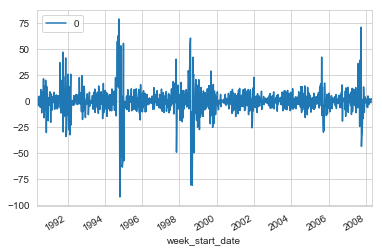

In [13]:
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()

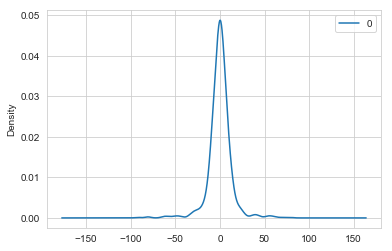

In [14]:
residuals.plot(kind='kde')

## Other time-series models

Vector autoregression (VAR) model.

- VAR is a stocastic process model used to capture independencies among multiple time series.
- VAR model generalizes AR model by allowing more than one variable.
- Each variable has a equation that explain the evolution based on its own lagged values, the lagged values of ther model variables and a error term. 